In [1]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
import random
import io
import sys
import logging
from new_strategy import TradingStrategy, Asset, BetSizingMethod, get_bet_sizing
from meta_strategy import MetaLabelingStrategy
import nbimporter
from backtest import Backtest
from add_features import generate_meta_labeled_data, merge_with_raw_features
from metalabel_backtest import MetaModelHandler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
import random
import lightgbm as lgb


%load_ext autoreload
%autoreload 2



2025-08-12 13:26:18,742 - INFO - Strategy initialized for BTCUSD using FixedFractionalBetSizing


📊 Data Split:
  → Training: 2104704 samples (80.0%)
  → Testing:  526176 samples (20.0%)

🔄 Running training phase...

📊 Rolling Window Debug (last 30 trades):
  y_true counts: [13 17]
  y_pred counts: [15 15]

📊 Rolling Window Debug (last 30 trades):
  y_true counts: [20 10]
  y_pred counts: [ 8 22]

📊 Rolling Window Debug (last 30 trades):
  y_true counts: [19 11]
  y_pred counts: [ 8 22]

📊 Rolling Window Debug (last 30 trades):
  y_true counts: [14 16]
  y_pred counts: [14 16]

📊 Rolling Window Debug (last 30 trades):
  y_true counts: [15 15]
  y_pred counts: [13 17]

📊 Rolling Window Debug (last 30 trades):
  y_true counts: [14 16]
  y_pred counts: [12 18]

📊 Rolling Window Debug (last 30 trades):
  y_true counts: [19 11]
  y_pred counts: [ 9 21]

📊 Rolling Window Debug (last 30 trades):
  y_true counts: [15 15]
  y_pred counts: [12 18]

📊 Rolling Window Debug (last 30 trades):
  y_true counts: [15 15]
  y_pred counts: [12 18]

📊 Rolling Window Debug (last 30 trades):
  y_true cou

[I 2025-08-12 13:36:12,206] A new study created in memory with name: no-name-61a0e0e2-10e4-4d0f-82be-3806339525d8


✅ Training data saved to results_metalabel/train_data_debug.csv

🤖 Training meta-model with cross-validation...

📊 Sanity Check for LONG dataset
  → Shape: (2753, 20)
  → NaNs in X: 0
  → All-zero columns: 0
  → y balance: [1580 1173]
[Optuna] Tuning LONG model...


[I 2025-08-12 13:36:12,502] Trial 0 finished with value: 0.5541669197139301 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.038052091892039265, 'num_leaves': 83, 'max_depth': 1, 'min_child_samples': 55, 'min_split_gain': 0.05808361216819946, 'colsample_bytree': 0.9464704583099741, 'reg_alpha': 3.005575058716044, 'reg_lambda': 3.540362888980227, 'top_rate': 0.10617534828874074, 'other_rate': 0.19398197043239887}. Best is trial 0 with value: 0.5541669197139301.
[I 2025-08-12 13:36:12,704] Trial 1 finished with value: 0.5773132949568277 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.008277688526305602, 'num_leaves': 26, 'max_depth': 3, 'min_child_samples': 162, 'min_split_gain': 0.43194501864211576, 'colsample_bytree': 0.7164916560792167, 'reg_alpha': 3.0592644736118975, 'reg_lambda': 0.6974693032602092, 'subsample': 0.7168578594140873, 'subsample_freq': 2}. Best is trial 1 with value: 0.5773132949568277.
[I 2025-08-12 13:36:13,823] Trial 2 finished with value: 

✅ Best parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.018005347566802606, 'num_leaves': 256, 'max_depth': 5, 'min_child_samples': 88, 'min_split_gain': 0.9951356819686632, 'colsample_bytree': 0.7442968084843167, 'reg_alpha': 1.83689443610008, 'reg_lambda': 1.9925931745709082, 'subsample': 0.6146264549987273, 'subsample_freq': 6, 'objective': 'binary', 'n_estimators': 100, 'random_state': 42, 'n_jobs': -1, 'verbosity': -1}
📈 Best CV AUC: 0.5974 (mean best_iter ≈ 29)
[SHAP-OOF] Summary CSV saved to results_metalabel/shap/shap_summary_btcusd_fixed_long.csv
[SHAP-OOF] Plot saved to results_metalabel/shap/shap_btcusd_fixed_long.png
[LONG] Selected features (pct >= 5%): ['attempt', 'pos_in_day_range', 'range15m_voladj', 'atr_z_60', 'rolling_f1', 'range_15m']

[LONG] score spread: min 0.247 | max 0.609 | std 0.069 | q05 0.309 | q95 0.533
[LONG] OOF metrics → {'AUC_OOF': 0.5303543872144345, 'PR_AUC_OOF': 0.45583614867805794, 'Brier_OOF': 0.27695695521212876, 'LogLoss_OOF': 3.18460258

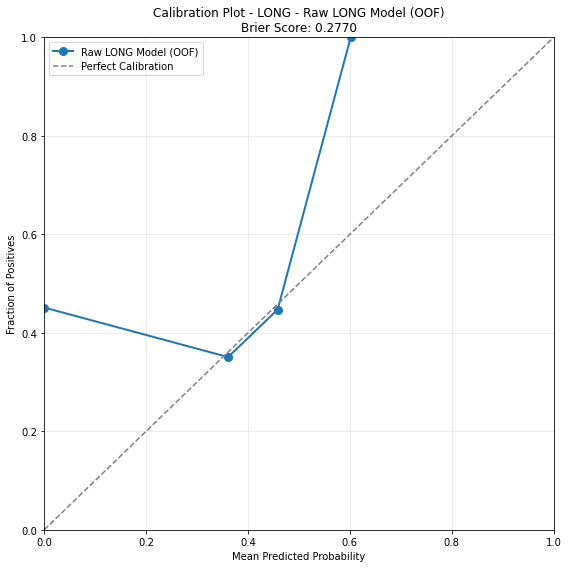

[I 2025-08-12 13:36:37,739] A new study created in memory with name: no-name-b3dff5c7-9552-4956-b140-114e863c687e


✅ Calibration plot created successfully

📊 Sanity Check for SHORT dataset
  → Shape: (2458, 21)
  → NaNs in X: 0
  → All-zero columns: 0
  → y balance: [1321 1137]
[Optuna] Tuning SHORT model...


[I 2025-08-12 13:36:37,960] Trial 0 finished with value: 0.5881998812758148 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.038052091892039265, 'num_leaves': 83, 'max_depth': 1, 'min_child_samples': 55, 'min_split_gain': 0.05808361216819946, 'colsample_bytree': 0.9464704583099741, 'reg_alpha': 3.005575058716044, 'reg_lambda': 3.540362888980227, 'top_rate': 0.10617534828874074, 'other_rate': 0.19398197043239887}. Best is trial 0 with value: 0.5881998812758148.
[I 2025-08-12 13:36:38,144] Trial 1 finished with value: 0.5624278180383637 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.008277688526305602, 'num_leaves': 26, 'max_depth': 3, 'min_child_samples': 162, 'min_split_gain': 0.43194501864211576, 'colsample_bytree': 0.7164916560792167, 'reg_alpha': 3.0592644736118975, 'reg_lambda': 0.6974693032602092, 'subsample': 0.7168578594140873, 'subsample_freq': 2}. Best is trial 0 with value: 0.5881998812758148.
[I 2025-08-12 13:36:38,844] Trial 2 finished with value: 

✅ Best parameters: {'boosting_type': 'goss', 'learning_rate': 0.04192258835374944, 'num_leaves': 88, 'max_depth': 11, 'min_child_samples': 85, 'min_split_gain': 0.5848226009680414, 'colsample_bytree': 0.7805845204359796, 'reg_alpha': 1.605903430039777, 'reg_lambda': 3.6372078545535107, 'top_rate': 0.3369193602429909, 'other_rate': 0.010467450088983393, 'objective': 'binary', 'n_estimators': 100, 'random_state': 42, 'n_jobs': -1, 'verbosity': -1, 'subsample': 1.0, 'subsample_freq': 0}
📈 Best CV AUC: 0.6019 (mean best_iter ≈ 24)
[SHAP-OOF] Summary CSV saved to results_metalabel/shap/shap_summary_btcusd_fixed_short.csv
[SHAP-OOF] Plot saved to results_metalabel/shap/shap_btcusd_fixed_short.png
[SHORT] Selected features (pct >= 5%): ['attempt', 'range15m_voladj', 'ret30m_voladj', 'pos_in_day_range', 'volume_shifted', 'rolling_f1', 'avg_return_30d', 'vol_15m']

[SHORT] score spread: min 0.242 | max 0.722 | std 0.081 | q05 0.345 | q95 0.614
[SHORT] OOF metrics → {'AUC_OOF': 0.555223548696151

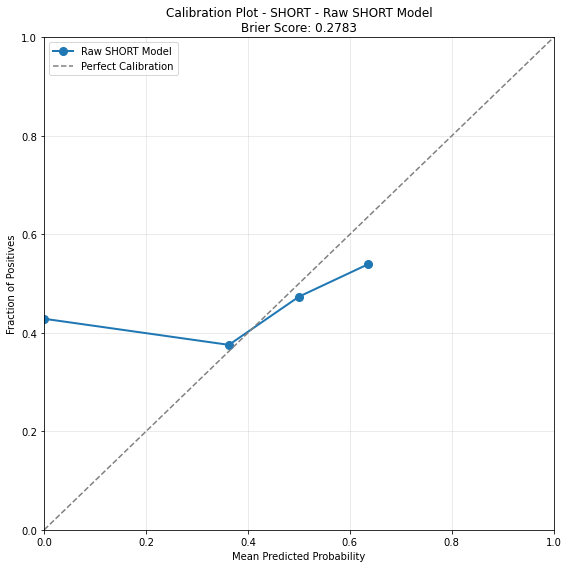

✅ Calibration plot created successfully

📊 Stored OOF distributions:
  LONG: 2753 samples, range [0.0000, 0.6016]
  SHORT: 2458 samples, range [0.0000, 0.7427]


2025-08-12 13:36:59,097 - INFO - Strategy initialized for BTCUSD using FixedFractionalBetSizing
2025-08-12 13:37:30,887 - INFO - Strategy initialized for BTCUSD using FixedFractionalBetSizing



🔍 Entry Time Check (from shared_signals dict):
Type: <class 'dict'>
Keys in shared_signals: ['asian', 'london', 'us']
Type of entry_time: <class 'pandas._libs.tslibs.timestamps.Timestamp'>


2025-08-12 13:37:31,241 - INFO - Strategy initialized for BTCUSD using FixedFractionalBetSizing
2025-08-12 13:37:31,316 - INFO - Strategy initialized for BTCUSD using FixedFractionalBetSizing



📊 Baseline features in .data:
['open', 'high', 'low', 'close', 'volume', 'date', 'daily_high', 'daily_low', 'daily_close', 'true_range', 'atr_14', 'ma_14', 'ma_30', 'ma_100', 'day_of_week', 'week_number', 'hour_of_day', 'max_price_14', 'min_price_14', 'max_price_30', 'min_price_30', 'max_price_100', 'min_price_100', 'drawdown_static', 'drawdown_30', 't10yie', 'cpiaucsl', 'vix_close', 'dtwexbgs', 'dgs10', 'ret_5m', 'ret_15m', 'ret_30m', 'vol_5m', 'vol_15m', 'vol_30m', 'range_5m', 'range_15m', 'atr_z_60', 'vix_z_60', 'ma14_slope_5', 'ret30m_voladj', 'vol_ratio_5_30', 'range15m_voladj', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'skew_30', 'kurt_30', 'vixz_x_ret30m', 'breakout_30_up', 'breakout_30_dn', 'pos_in_day_range', 'daily_return', 'daily_volatility', 'regime', 'regime_label', 'avg_return_30d', 'volume_shifted']

📊 Filtered features in .data:
['open', 'high', 'low', 'close', 'volume', 'date', 'daily_high', 'daily_low', 'daily_close', 'true_range', 'atr_14', 'ma_14', 'ma_30', 'ma

2025-08-12 13:37:54,759 - INFO - Exported detailed trades to data/results/trades_detailed_BTCUSD_fixed.csv
2025-08-12 13:37:54,820 - INFO - Saved backtest results to data/results/backtest_results_BTCUSD_fixed.txt



=== BTCUSD Backtest Results ===
Bet Sizing Strategy: fixedfractionalbetsizing

Period: 2024-01-02 to 2024-12-31

ASIAN Session Performance:
Initial Capital: $100,000.00
Final Capital: $98,908.20
Total PnL: $-1,091.80
Return: -1.09%
Win Rate: 41.44% (201W/284L)
Max Drawdown: 1.91%
Sharpe Ratio: -0.58
Skewness: 0.668
Excess Kurtosis: -0.996

Attempt Analysis:

  Attempt 1:
  Trades: 260 (53.6% of session trades)
  PnL: $-1,463.57
  Win Rate: 44.62% (116W/144L)
  Average Win: $48.89
  Average Loss: $-49.55

  Attempt 2:
  Trades: 144 (29.7% of session trades)
  PnL: $353.37
  Win Rate: 39.58% (57W/87L)
  Average Win: $78.59
  Average Loss: $-47.43

  Attempt 3:
  Trades: 81 (16.7% of session trades)
  PnL: $18.40
  Win Rate: 34.57% (28W/53L)
  Average Win: $84.24
  Average Loss: $-44.16

LONDON Session Performance:
Initial Capital: $100,000.00
Final Capital: $102,854.38
Total PnL: $2,854.38
Return: 2.85%
Win Rate: 48.31% (215W/230L)
Max Drawdown: 0.60%
Sharpe Ratio: 1.59
Skewness: 0.581


2025-08-12 13:37:55,367 - INFO - Exported detailed trades to data/results/trades_detailed_BTCUSD_fixed.csv
2025-08-12 13:37:55,423 - INFO - Saved backtest results to data/results/backtest_results_BTCUSD_fixed.txt



=== BTCUSD Backtest Results ===
Bet Sizing Strategy: fixedfractionalbetsizing

Period: 2024-01-02 to 2024-12-31

ASIAN Session Performance:
Initial Capital: $100,000.00
Final Capital: $98,915.65
Total PnL: $-1,084.35
Return: -1.08%
Win Rate: 42.45% (59W/80L)
Max Drawdown: 1.41%
Sharpe Ratio: -2.41
Skewness: 0.363
Excess Kurtosis: -1.769

Attempt Analysis:

  Attempt 1:
  Trades: 111 (79.9% of session trades)
  PnL: $-677.24
  Win Rate: 44.14% (49W/62L)
  Average Win: $48.88
  Average Loss: $-49.56

  Attempt 2:
  Trades: 17 (12.2% of session trades)
  PnL: $-423.97
  Win Rate: 29.41% (5W/12L)
  Average Win: $34.55
  Average Loss: $-49.73

  Attempt 3:
  Trades: 11 (7.9% of session trades)
  PnL: $16.87
  Win Rate: 45.45% (5W/6L)
  Average Win: $57.67
  Average Loss: $-45.25

LONDON Session Performance:
Initial Capital: $100,000.00
Final Capital: $101,344.58
Total PnL: $1,344.58
Return: 1.34%
Win Rate: 56.82% (75W/57L)
Max Drawdown: 0.20%
Sharpe Ratio: 2.83
Skewness: 0.085
Excess Kurto


🔹 Baseline Strategy:
  Bear: Trades = 928, Avg PnL = 0.48, Total PnL = 442.41, Win Rate = 42.56%
  Bull: Trades = 23, Avg PnL = -2.64, Total PnL = -60.73, Win Rate = 52.17%
  Neutral: Trades = 457, Avg PnL = 2.72, Total PnL = 1244.64, Win Rate = 45.08%


🔹 Meta-Filtered Strategy:
  Bear: Trades = 247, Avg PnL = -1.48, Total PnL = -365.43, Win Rate = 47.37%
  Bull: Trades = 15, Avg PnL = -2.06, Total PnL = -30.95, Win Rate = 53.33%
  Neutral: Trades = 151, Avg PnL = 3.61, Total PnL = 545.53, Win Rate = 49.67%


✅ CSVs saved to: results_metalabel
 - baseline_btcusd_fixed.csv
 - filtered_btcusd_fixed.csv

✅ Summaries saved to:
 - baseline_btcusd_fixed.txt
 - filtered_btcusd_fixed.txt

✅ Full evaluation written to: results_metalabel/comparison/evaluation_btcusd_fixed.txt


In [2]:
def split_price_data(price_data: pd.DataFrame, split_ratio: float = 0.7):
    split_idx = int(len(price_data) * split_ratio)
    return price_data.iloc[:split_idx], price_data.iloc[split_idx:]

def run_training_phase(asset: Asset, method: BetSizingMethod, price_data: pd.DataFrame):
    # Run base strategy
    past_returns = price_data['close'].pct_change().dropna()
    bet_sizing = get_bet_sizing(method, past_returns)
    
    strategy = TradingStrategy(price_data, asset.value, bet_sizing, method)
    strategy.generate_signals()
    strategy.simulate_trades()
    
    trade_df = strategy.get_trade_data()
    labeled = generate_meta_labeled_data(trade_df)
    #labeled_with_features = merge_with_raw_features(labeled, asset.value)
    labeled_with_features = labeled
    
    print(labeled_with_features.columns)
    return labeled_with_features

def train_meta_model(train_df: pd.DataFrame, 
                     long_feature_cols: list, short_feature_cols: list,
                     asset, method) -> MetaModelHandler:
    """
    Modified to use only training data with cross-validation instead of separate validation set.
    """
    # Shift rolling metrics to avoid lookahead bias
    rolling_cols = [
        'rolling_f1', 'rolling_accuracy', 'rolling_precision', 'rolling_recall',
        'n_total_seen', 'n_window_obs'
    ]
    for col in rolling_cols:
        if col in train_df.columns:
            train_df[col] = train_df.groupby('session')[col].shift(1)

    # Remove any 'set' column if it exists
    if 'set' in train_df.columns:
        train_df = train_df.drop('set', axis=1)

    meta_model = MetaModelHandler()
    meta_model.train(
        trades_df=train_df,  # Only pass training data
        long_feature_cols=long_feature_cols,
        short_feature_cols=short_feature_cols,
        asset_name=asset.value,
        method_name=method.value,
    )

    return meta_model


def run_parallel_evaluation(asset, method, test_price_data, signals, meta_model, feature_cols):
    past_returns = test_price_data['close'].pct_change().dropna()
    bet_sizing = get_bet_sizing(method, past_returns)

    #  First, initialize Meta strategy to access feature-enriched data
    meta_strategy = MetaLabelingStrategy(
        test_price_data.copy(), asset.value, bet_sizing, method,
        meta_model_handler=meta_model
    )
    feature_data = meta_strategy.data.copy()

    #  Use feature_data for both strategies
    baseline = TradingStrategy(feature_data.copy(), asset.value, bet_sizing, method)
    baseline.trade_signals = signals

    filtered = MetaLabelingStrategy(feature_data.copy(), asset.value, bet_sizing, method, meta_model_handler=meta_model,feature_cols=feature_cols)
    filtered.trade_signals = signals

    print("\n📊 Baseline features in .data:")
    print(baseline.data.columns.tolist())

    print("\n📊 Filtered features in .data:")
    print(filtered.data.columns.tolist())
    print("\n🕒 Baseline index:", baseline.data.index.name, baseline.data.index.dtype)
    print("🕒 Filtered index:", filtered.data.index.name, filtered.data.index.dtype)

    baseline.simulate_trades()
    filtered.simulate_trades()

    return baseline, filtered

def compare_backtests(baseline: TradingStrategy, filtered: MetaLabelingStrategy, asset: Asset, method: BetSizingMethod):
    def capture_regime_stats(strategy, name):
        buffer = io.StringIO()
        sys.stdout = buffer
        print(f"\n🔹 {name} Strategy:")

        df = strategy.get_trade_data()

        if 'regime_label' not in df.columns or 'pnl' not in df.columns:
            print("Required columns not found in trade data.")
        else:
            grouped = df.groupby('regime_label')

            for regime, group in grouped:
                trades = len(group)
                avg_pnl = group['pnl'].mean()
                total_pnl = group['pnl'].sum()
                wins = (group['pnl'] > 0).sum()
                winrate = wins / trades if trades > 0 else 0

                print(f"  {regime}: Trades = {trades}, "
                      f"Avg PnL = {avg_pnl:.2f}, Total PnL = {total_pnl:.2f}, "
                      f"Win Rate = {winrate:.2%}")

        sys.stdout = sys.__stdout__
        return buffer.getvalue()
    
    print("\n[BASELINE]")
    baseline_bt = Backtest(baseline)
    baseline_bt.run_analysis()
    baseline_buffer = io.StringIO()
    sys.stdout = baseline_buffer
    baseline_bt.print_summary()
    sys.stdout = sys.__stdout__
    baseline_summary = baseline_buffer.getvalue()
    print(baseline_summary)

    print("\n[META-FILTERED]")
    filtered_bt = Backtest(filtered)
    filtered_bt.run_analysis()
    filtered_buffer = io.StringIO()
    sys.stdout = filtered_buffer
    filtered_bt.print_summary()
    sys.stdout = sys.__stdout__
    filtered_summary = filtered_buffer.getvalue()
    print(filtered_summary)

    print(f"\nTrades Rejected by Meta-Model: {filtered.rejected_trades}")

    output_dir = "results_metalabel"
    os.makedirs(output_dir, exist_ok=True)

    asset_name = asset.value.lower()
    method_name = method.value.lower()

    baseline_csv = f"baseline_{asset_name}_{method_name}.csv"
    filtered_csv = f"filtered_{asset_name}_{method_name}.csv"
    baseline_txt = f"baseline_{asset_name}_{method_name}.txt"
    filtered_txt = f"filtered_{asset_name}_{method_name}.txt"

    baseline.get_trade_data().to_csv(os.path.join(output_dir, baseline_csv), index=False)
    filtered.get_trade_data().to_csv(os.path.join(output_dir, filtered_csv), index=False)

    """with open(os.path.join(output_dir, baseline_txt), "w") as f:
        f.write(baseline_summary)

    with open(os.path.join(output_dir, filtered_txt), "w") as f:
        f.write(filtered_summary)"""
    
        # Run and print regime comparisons
    print("\n📈 Regime Comparison")
    regime_baseline = capture_regime_stats(baseline, "Baseline")
    regime_filtered = capture_regime_stats(filtered, "Meta-Filtered")

    print(regime_baseline)
    print(regime_filtered)

    """# Append to the already existing summary files
    with open(baseline_txt, "a") as f:
        f.write("\n\n=== Regime Analysis ===\n")
        f.write(regime_baseline)

    with open(filtered_txt, "a") as f:
        f.write("\n\n=== Regime Analysis ===\n")
        f.write(regime_filtered)"""

    print(f"\n✅ CSVs saved to: {output_dir}")
    print(f" - {baseline_csv}")
    print(f" - {filtered_csv}")
    print(f"\n✅ Summaries saved to:")
    print(f" - {baseline_txt}")
    print(f" - {filtered_txt}")

def evaluate_backtest_and_regimes(
    baseline_path: str,
    filtered_path: str,
    txt_output_path: str = "results_metalabel/comparison/evaluation_summary.txt"
):
    buffer = io.StringIO()
    sys.stdout = buffer  # Redirect print to buffer

    print("\n📊 Evaluation from Final CSVs")

    def compute_backtest_kpis(df: pd.DataFrame, label: str):
        print(f"\n📈 {label} Backtest Summary (Per Session Evaluation)")

        df = df[df['position_size'] > 0]

        if 'pnl' not in df.columns or 'session' not in df.columns:
            print("❌ Missing required columns ('pnl', 'session').")
            return

        session_stats = []

        for session, group in df.groupby("session"):
            group = group.sort_values("exit_time")

            if group.empty:
                continue

            # Build capital curve on actual trade exits
            capital = 100_000  # consistent with old method
            capital_curve = []

            for pnl in group['pnl']:
                capital += pnl
                capital_curve.append(capital)

            group = group.copy()
            group['capital_curve'] = capital_curve
            returns = pd.Series(capital_curve).pct_change().dropna()

            # Sharpe: based on trading days only
            if len(returns) >= 2:
                mean_return = returns.mean()
                vol = returns.std()
                sharpe = (mean_return / vol) * np.sqrt(252) if vol > 0 else 0
            else:
                sharpe = 0

            # Max drawdown from capital curve
            cumulative = pd.Series(capital_curve).cummax()
            drawdown = (cumulative - capital_curve) / cumulative
            max_drawdown = drawdown.max()

            wins = (group['pnl'] > 0).sum()
            losses = (group['pnl'] <= 0).sum()
            win_rate = wins / (wins + losses) if (wins + losses) > 0 else 0

            total_pnl = group["pnl"].sum()
            final_capital = capital_curve[-1]

            session_stats.append({
                "session": session,
                "total_pnl": total_pnl,
                "final_capital": final_capital,
                "win_rate": win_rate,
                "sharpe": sharpe,
                "max_drawdown": max_drawdown,
                "trades": len(group)
            })

            print(f"\n🔹 Session: {session}")
            print(f"  Final Capital: ${final_capital:,.2f}")
            print(f"  Total PnL:     ${total_pnl:,.2f}")
            print(f"  Win Rate:      {win_rate:.2%} ({wins}W / {losses}L)")
            print(f"  Max Drawdown:  {max_drawdown:.2%}")
            print(f"  Sharpe Ratio:  {sharpe:.2f}")
            print(f"  Total Trades:  {len(group)}")

        # Optional combined stats
        combined_pnl = sum(s["total_pnl"] for s in session_stats)
        print(f"\n📊 Combined PnL across all sessions: ${combined_pnl:,.2f}")


    def compute_regime_stats(df: pd.DataFrame, label: str):
        print(f"\n📊 {label} Regime Breakdown by Session")

        if "regime_label" not in df.columns or "pnl" not in df.columns or "session" not in df.columns:
            print("❌ Missing required columns ('regime_label', 'pnl', or 'session').")
            return

        session_groups = df.groupby("session")
        for session, session_df in session_groups:
            print(f"\n🔹 Session: {session}")
            regime_groups = session_df.groupby("regime_label")
            for regime, group in regime_groups:
                trades = len(group)
                avg_pnl = group["pnl"].mean()
                total_pnl = group["pnl"].sum()
                wins = (group["pnl"] > 0).sum()
                win_rate = wins / trades if trades > 0 else 0

                print(f"  - Regime: {regime}")
                print(f"    Trades:    {trades}")
                print(f"    Avg PnL:   ${avg_pnl:.2f}")
                print(f"    Total PnL: ${total_pnl:.2f}")
                print(f"    Win Rated:  {win_rate:.2%}")


    # === Load CSVs ===
    baseline_df = pd.read_csv(baseline_path, parse_dates=["entry_time", "exit_time"])
    filtered_df = pd.read_csv(filtered_path, parse_dates=["entry_time", "exit_time"])

    # === Compute Metrics ===
    compute_backtest_kpis(baseline_df, "Baseline")
    compute_regime_stats(baseline_df, "Baseline")

    compute_backtest_kpis(filtered_df, "Meta-Filtered")
    compute_regime_stats(filtered_df, "Meta-Filtered")

    # === Write output to TXT file ===
    sys.stdout = sys.__stdout__  # Restore stdout
    with open(txt_output_path, "w") as f:
        f.write(buffer.getvalue())

    print(f"\n✅ Full evaluation written to: {txt_output_path}")


if __name__ == "__main__":
    logging.basicConfig(level=logging.INFO)


    asset = Asset.BTCUSD
    method = BetSizingMethod.FIXED

    #long_feature_cols = ["session_code","open","attempt","rolling_f1","rolling_accuracy","ret30m_voladj","ma14_slope_5","pos_in_day_range","vol_ratio_5_30","range15m_voladj","drawdown_30","daily_volatility","avg_return_30d","hour_sin","hour_cos","dow_sin","dow_cos","volume_shifted","breakout_30_up","breakout_30_dn","t10yie","dgs10","dtwexbgs"]
    #short_feature_cols = ["session_code","open","attempt","rolling_f1","rolling_accuracy","ret30m_voladj","ma14_slope_5","pos_in_day_range","vol_ratio_5_30","range15m_voladj","drawdown_30","daily_volatility","avg_return_30d","hour_sin","hour_cos","dow_sin","dow_cos","volume_shifted","breakout_30_up","breakout_30_dn","t10yie","dgs10","dtwexbgs"]

    long_feature_cols = ["attempt", "pos_in_day_range", "daily_volatility", "rolling_f1", "volume_shifted", "atr_z_60", "dgs10", "range15m_voladj", "ret_30m", "vol_15m", "ma14_slope_5", "dtwexbgs", "range_15m", "open", "avg_return_30d","ret30m_voladj","atr_14","drawdown_30","vol_30m","hour_of_day",
]

    short_feature_cols = ["attempt", "ret30m_voladj", "avg_return_30d", "ret_30m", "range15m_voladj", "ma14_slope_5", "volume_shifted", "atr_z_60", "cpiaucsl", "dtwexbgs", "open", "rolling_f1", "drawdown_30", "pos_in_day_range", "vol_ratio_5_30","vol_ratio_5_30","daily_volatility","vol_5m","atr_14","ma_14","vol_15m"
]

    price_path = Path(f"data/processed/{asset.value}/combined_data.csv")
    price_data = pd.read_csv(price_path, index_col='timestamp', parse_dates=True)

    # Modified split: Only train and test (no validation set)
    n = len(price_data)
    train_size = int(n * 0.8)  # Increased from 0.6 to 0.8 since we're not using validation

    train_data = price_data.iloc[:train_size]
    test_data = price_data.iloc[train_size:]

    print(f"📊 Data Split:")
    print(f"  → Training: {len(train_data)} samples ({len(train_data)/len(price_data):.1%})")
    print(f"  → Testing:  {len(test_data)} samples ({len(test_data)/len(price_data):.1%})")


    # Training - only on training data, no separate validation
    print("\n🔄 Running training phase...")
    train_trades = run_training_phase(asset, method, train_data)

    # Clean features
    all_features = list(set(long_feature_cols + short_feature_cols))
    train_trades_cleaned = train_trades.replace([np.inf, -np.inf], np.nan).dropna(subset=all_features)

    train_trades_cleaned.to_csv("results_metalabel/train_data_debug.csv", index=False)
    print("✅ Training data saved to results_metalabel/train_data_debug.csv")

    # Train meta-model using cross-validation (no separate validation set)
    print("\n🤖 Training meta-model with cross-validation...")
    meta_model = train_meta_model(
    train_trades_cleaned,  # Only pass training data
    long_feature_cols,
    short_feature_cols,
    asset,
    method
)

    # Reuse signals
    signal_gen = TradingStrategy(test_data.copy(), asset.value, get_bet_sizing(method), method)
    signal_gen.generate_signals()
    shared_signals = signal_gen.trade_signals

    print("\n🔍 Entry Time Check (from shared_signals dict):")
    print("Type:", type(shared_signals))
    print("Keys in shared_signals:", list(shared_signals.keys()))

    # Try to peek at the first signal (depending on structure)
    first_key = next(iter(shared_signals))
    first_signal_list = shared_signals[first_key]
    first_signal = first_signal_list[0]  # Get the first signal from the list
    print("Type of entry_time:", type(first_signal['entry_time']))

    # Evaluation
    base_strat, filtered_strat = run_parallel_evaluation(
        asset, method, test_data, shared_signals, meta_model, all_features
    )

    # Compare
    compare_backtests(base_strat, filtered_strat, asset, method)
    evaluate_backtest_and_regimes(
    baseline_path=f"results_metalabel/baseline_{asset.value.lower()}_{method.value.lower()}.csv",
    filtered_path=f"results_metalabel/filtered_{asset.value.lower()}_{method.value.lower()}.csv",
    txt_output_path=f"results_metalabel/comparison/evaluation_{asset.value.lower()}_{method.value.lower()}.txt"

)
